# Notebook Imports

In [189]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud

from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [221]:
EXAMPLE_FILE = './SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = './SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = './SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM1_PATH = './SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM2_PATH = './SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

JSON_FILE = './SpamData/01_Processing/email-text-data.json'
WHALE_FILE = './SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = './SpamData/01_Processing/wordcloud_resources/skull-icon.png'

THUMBS_UP_FILE = './SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = './SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

VOCAB_SIZE = 2500
WORD_ID_FILE = './SpamData/01_Processing/word-by-id.csv'
TRAINING_DATA_FILE = './SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = './SpamData/02_Training/test-data.txt'

# Reading Files

In [4]:
f = open(EXAMPLE_FILE)
message = f.read()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:


email_body = message[message.index('\n\n\n')+2:]
print( email_body )


Dear Mr Still

Good tidings to you and all your staff for the festive season ahead (Christmas).
Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.
But WAIT! You're probably thinking: "What makes him so special?"
Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.
You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.
I look forward to hearing from you.

Best wishes
Robin Cooper
[Excerpt from the book: The Timewaster Letters by Robi

# Generator Functions

In [6]:
def generate_square(N):
    for i in range(N):
        yield i ** 2

In [7]:
type( generate_square( 3 ) )

## What it does is basically the function is not called once;
## but after it faces the first yield, the function stops midway( different from normal function )
## it saves its state and return the value
## after the loop has finished, it resumes its state again

for i in generate_square(3):
    print(i , end = ' -> ')

0 -> 1 -> 4 -> 

## Email Body Extraction

In [8]:
def email_body_generator(path):
    
    for root,dirname , filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root , file_name)
            
            f = open(filepath , encoding='latin-1')
            message = f.read()
            if '\n\n' not in message:
                email_body = ''
            else:
                email_body = message[message.index('\n\n')+2:]
            
            yield file_name , email_body


In [9]:
def df_from_directory( path , classification ):
    rows = []
    row_names = []
    
    for file_name , email_body in email_body_generator( path ):
        rows.append({'MESSAGE' : email_body , 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame( rows , index=row_names  )

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH , SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH , SPAM_CAT))

In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory( EASY_NONSPAM1_PATH , HAM_CAT )
ham_emails = ham_emails.append(df_from_directory( EASY_NONSPAM2_PATH , HAM_CAT ))

In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat( [ spam_emails ,ham_emails ] )
print('Shape of entire data frame : ' , data.shape )
data.head()

Shape of entire data frame :  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n1) Slim Down ...,1


# Data Cleaning: Checking for missing values

In [15]:
# check if message bodies are null
data.MESSAGE.isnull().values.any()

False

In [16]:
(data.MESSAGE.str.len() == 0).any()

True

In [17]:
(data.MESSAGE.str.len() == 0).sum()

3

In [18]:
data.MESSAGE.isnull().sum()

0

## Locate empty emails

In [19]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [20]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System Files from Dataframe

In [21]:
data.drop(['cmds'] , inplace=True)

data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [22]:
document_ids = range(0,len(data.index))
data['doc_id'] = document_ids

In [23]:
data['FILE_NAME'] = data.index
data.set_index('doc_id' , inplace = True)

data.head()

,MESSAGE,CATEGORY,FILE_NAME
doc_id,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n1) Slim Down ...,1,00005.57696a39d7d84318ce497886896bf90d


# Save to file using Pandas

In [24]:
data.to_json( JSON_FILE )

# Number of spam messages  (visualized)

In [25]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [26]:
amount_of_spams = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

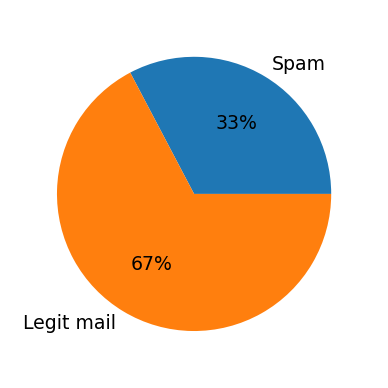

In [27]:
category_names = ['Spam' , 'Legit mail']
sizes = [ amount_of_spams , amount_of_ham ]

plt.figure( figsize=(2,2) , dpi=227)
plt.pie( sizes , labels= category_names , textprops={'fontsize':6}  , autopct = '%1.0f%%' )
plt.show()

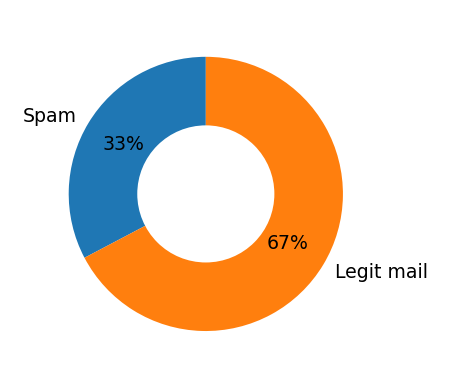

In [28]:
category_names = ['Spam' , 'Legit mail']
sizes = [ amount_of_spams , amount_of_ham ]

plt.figure( figsize=(2,2) , dpi=227)
plt.pie( sizes , labels= category_names , textprops={'fontsize':6}  ,startangle=90,  autopct = '%1.0f%%' , pctdistance=0.7 )
#         , explode = [0 , 0.01] )

# Draw Circle
center_circle = plt.Circle((0,0) , radius = 0.5 , fc = 'white')
plt.gca().add_artist(center_circle)
plt.show()

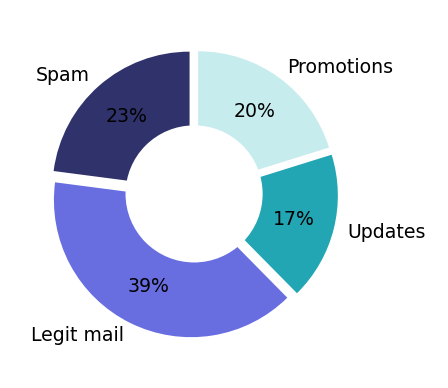

In [29]:
category_names = ['Spam' , 'Legit mail' , 'Updates' , 'Promotions']
sizes = [ 25, 43 , 19 , 22 ]
custom_colors = ['#30336b' , '#686de0' , '#22a6b3' , '#c7ecee']
offset = [0.05,0.05,0.05,0.05]

plt.figure( figsize=(2,2) , dpi=227)
plt.pie( sizes , labels= category_names , textprops={'fontsize':6}  , autopct = '%1.0f%%' ,startangle=90, colors = custom_colors ,  pctdistance=0.7 , explode = offset)

# Draw Circle
center_circle = plt.Circle((0,0) , radius = 0.5 , fc = 'white')
plt.gca().add_artist(center_circle)
plt.show()

# Natural Language Processing

## Text Preprocessing

In [30]:
msg = 'WOUEBc weoubcws uweqo,zqwwiNUWUIBcCB'
msg.lower()

'wouebc weoubcws uweqo,zqwwinuwuibccb'

## Download NLTK Resources ( Tokenizer & Stopwords)

In [31]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [91]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\shakespeare.zip.


True

## Tokenising

In [33]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ... ??? ? \
        Nobody expects the Spanish Inquisition.'
words = word_tokenize(msg.lower())

In [34]:
stop_words = set(stopwords.words('english'))

In [35]:
filtered_words = [ word for word in words if (word not in stop_words)]

In [36]:
filtered_words

['work',
 'play',
 'makes',
 'jack',
 'dull',
 'boy',
 '.',
 '.',
 '...',
 '?',
 '?',
 '?',
 '?',
 'nobody',
 'expects',
 'spanish',
 'inquisition',
 '.']

## Word Stemming

In [37]:
stemmer = PorterStemmer()
# List comprehension
filtered_words = [ stemmer.stem(word) for word in words if ( word not in stop_words  )]

In [38]:
filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 '.',
 '.',
 '...',
 '?',
 '?',
 '?',
 '?',
 'nobodi',
 'expect',
 'spanish',
 'inquisit',
 '.']

## Removing Punctuations

In [39]:
stemmer = PorterStemmer()
# List comprehension
filtered_words = [ stemmer.stem(word) for word in words if ( word not in stop_words and word.isalpha() )]

In [40]:
filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 'nobodi',
 'expect',
 'spanish',
 'inquisit']

## Removing HTML Tags from emails

In [41]:
soup = BeautifulSoup(data.at[213 , 'MESSAGE'] , 'html.parser')

In [42]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\nContent-Type: text/plain;\n\tcharset="Windows-1252"\nContent-Transfer-Encoding: quoted-printable\n\n We dare you...\n Try to find a better annuity!\n=20\n  - 5.40% Guaranteed for 6 Years=0A=\n- 6 Year Surrender Charge=0A=\n- 5% Agent\nCommission up to age 80=09\nCall today for more information!\n 800-888-7641 ext. 103\n- or -\n\nPlease fill out the form below for more information\t=20\nName:\t \t  =09\nE-mail:\t \t=20\nPhone:\t \t=20\nCity:\t \t State:\t \t=20\n \t    =09\n=20\n PMG Financial Services\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\ntotalling $25,000-$99,999.\t=20\nWe don\'t want anyone to receive our mailings who does not wish to\nreceive them. This is a professional communication sent to insurance\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\nthis message. Instead, go here: http://www.insuranceiq.com/optout\n=20\n\nLegal Notice

# Function for Email Processing

In [43]:
def clean_message( message , stemmer = PorterStemmer() , stop_words = set(stopwords.words('english')) ):
    
    # First convert to lower case
    # Second tokenize
    # Third check if the words in stop word
    # 4th remove punctuation
    # 5th return the stems only
    filtered_words = [stemmer.stem(word) for word in word_tokenize(message.lower()) if ( word.isalpha() and word not in stop_words )]
        
    return filtered_words

In [44]:
# clean_message( email_body )

In [45]:
def clean_message_no_html( message , stemmer = PorterStemmer() , stop_words = set(stopwords.words('english')) ):
    
    # First convert to lower case
    # Second tokenize
    # Third check if the words in stop word
    # 4th remove punctuation
    # 5th return the stems only
    soup = BeautifulSoup( message , 'html.parser' )
    cleaned_text = soup.get_text()
    filtered_words = [stemmer.stem(word) for word in word_tokenize(cleaned_text.lower()) if ( word.isalpha() and word not in stop_words )]
        
    return filtered_words

In [46]:
len(clean_message_no_html(data.at[213 , 'MESSAGE'] ))

92

# Apply Cleaning & Tokenisation to All Emails

## Slicing Dataframes and series and creating subsets

In [47]:
data.iat[213,2]

'00214.1367039e50dc6b7adb0f2aa8aba83216'

In [48]:
data.iloc[211:214]

,MESSAGE,CATEGORY,FILE_NAME
doc_id,,,
211,<HTML><HEAD>\n<META http-equiv=3DContent-Type ...,1,00212.a9947ad74a529a35d11538e1df60cd73
212,<p>We thank you for just a moment of your tim...,1,00213.8c42a1c257aa30ff3b3ba668cca59408
213,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216


In [49]:
first_emails = data.MESSAGE.iloc[211:214]

nested_list = first_emails.apply(clean_message)

In [50]:
flat_list = [ item for sublist in nested_list for item in sublist ]

len(flat_list)

382

In [51]:
%%time

# use apply() on all messages in the dataframe
nested_list = data.MESSAGE.apply( clean_message_no_html )

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 1min 33s


In [52]:
nested_list.tail()

doc_id
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using logic to slice dataframe

In [53]:
data[ data.CATEGORY == 1].shape

(1896, 3)

In [69]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0 ].index
type( doc_ids_ham )

pandas.core.indexes.numeric.Int64Index

## Subsetting a series with index

In [70]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [71]:
nested_list_ham.shape

(3900,)

In [74]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [82]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

20815

In [83]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [85]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]

13242

In [86]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating A New Cloud

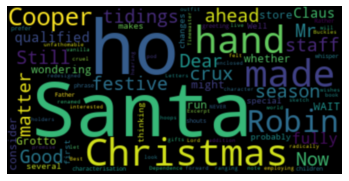

In [90]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud , interpolation='bicubic')
plt.axis('off')
plt.show()

In [92]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [93]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [98]:
# Preprocessing before feeding to the word cloud
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

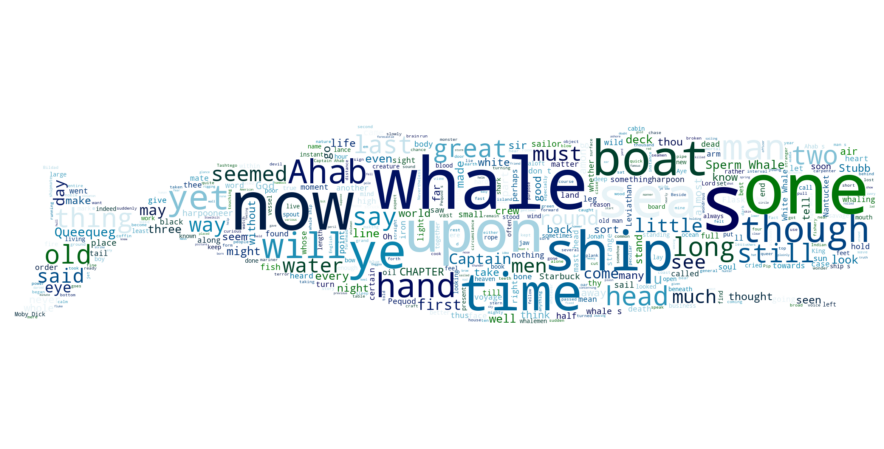

In [111]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB' , size = icon.size , color=(255,255,255))
image_mask.paste(icon , box = icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask = rgb_array , background_color='white' , max_words=500 , colormap='ocean').generate(novel_as_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud , interpolation='bilinear')
plt.axis('off')
plt.show()

In [120]:
example_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
len(example_corpus)

37360

In [121]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [122]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB' , size = icon.size , color=(255,255,255))
image_mask.paste(icon , box = icon)
rgb_array = np.array(image_mask)

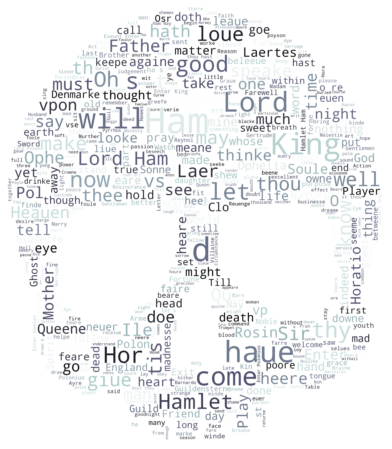

In [124]:
word_cloud = WordCloud(mask = rgb_array , background_color='white' , max_words=500 , colormap='bone').generate(novel_as_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud , interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham & Spam Messages

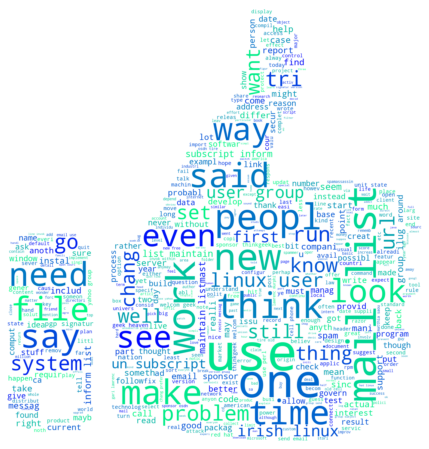

In [127]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB' , size = icon.size , color=(255,255,255))
image_mask.paste(icon , box = icon)
rgb_array = np.array(image_mask)

# Generate the text as string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask = rgb_array , background_color='white' , max_words=500 , colormap='winter').generate(ham_str)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud , interpolation='bilinear')
plt.axis('off')
plt.show()

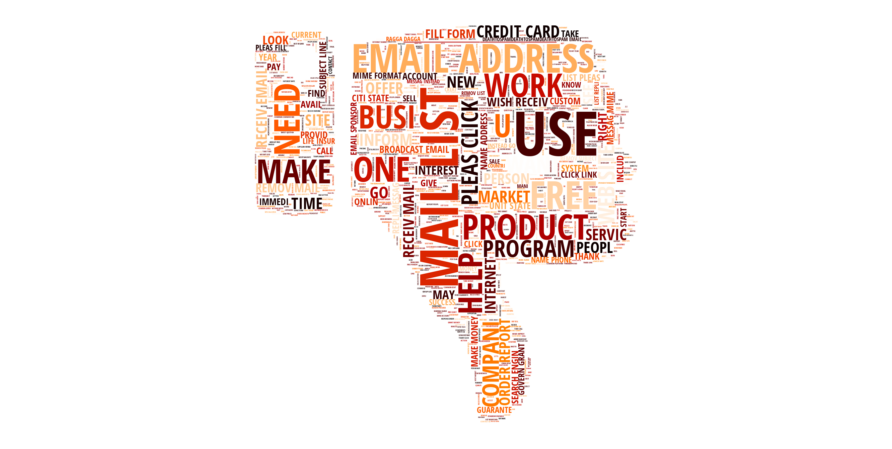

In [132]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB' , size = icon.size , color=(255,255,255))
image_mask.paste(icon , box = icon)
rgb_array = np.array(image_mask)

# Generate the text as string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(font_path= './SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf' , mask = rgb_array , background_color='white' , max_words=1000 , colormap='gist_heat').generate(spam_str.upper())
plt.figure(figsize=[16,8])
plt.imshow(word_cloud , interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [133]:
stemmed_nest_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [ item for sublist in stemmed_nest_list for item in sublist]

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [136]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words: ', unique_words.shape[0])
unique_words.head()

Number of unique words:  27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [143]:
# Subset of only 2005 frequent words
frequent_words = unique_words[:VOCAB_SIZE]
print('First ten frequent words:\n', frequent_words[:10])

First ten frequent words:
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary Dataframe with Word-id

In [146]:
word_ids = list( range(0,VOCAB_SIZE) )
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values } , index= word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the vocabulary as a CSV file

In [148]:
vocab.to_csv(WORD_ID_FILE , index_label=vocab.index.name , header=vocab.VOCAB_WORD.name)

# Exercise: Check if a word is in the vocabulary

In [173]:
# inefficient
def check_in_vocabulary( word ):
    if word in vocab.VOCAB_WORD.values:
        return True
    else:
        return False

In [174]:
check_in_vocabulary('brewery')

False

In [175]:
any( vocab.VOCAB_WORD == 'machine' ) # inefficient

False

In [176]:
'machine' in set(vocab.VOCAB_WORD) # better

False

 # Exercise: Find the email with the most number of words

In [179]:
clean_email_lengths = [ len(sublist) for sublist in stemmed_nest_list ]
print('Largest email: ' , max(clean_email_lengths))

Largest email:  7671


In [180]:
print('Email position in the list( and the data dataframe) : ' , np.argmax(clean_email_lengths) )

Email position in the list( and the data dataframe) :  5775


In [184]:
stemmed_nest_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [185]:
data.at[np.argmax(clean_email_lengths) , 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n4 DVDs Free +s&p Join Now\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n---------------------------------------------------------------------~->\n\nA new version of unison is now available for testing.  It incorporates\nseveral small improvements over 2.9.1, but the main change is a fix to\na bug that had potentially serious safety consequences, but only for\nthe very small number of users that are in the habit of running more\nthan one instance of Unison at a time, in parallel.  These users are\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\nThe release includes pre-built executables for Linux and Solaris, but\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\nthe moment, none of the active developers are regularly using Unison\non Windows, and we do not have a machine that is configured properly\nfor building executables for export.)\n\nGrab it from here:\n   

# Generate Features & Sparse Matrix

### Creating a Dataframe with one word per column

In [188]:
word_columns_df = pd.DataFrame.from_records(stemmed_nest_list.to_list())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


### Splitting the data into training & testing Dataset

In [196]:
X_train , X_test , y_train, y_test = train_test_split( word_columns_df , data.CATEGORY , test_size = .3 , random_state = 42 )

In [199]:
X_train.index.name= X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [200]:
y_train.head()

doc_id
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a Sparse Matrix from Training Dataset

In [203]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [205]:
word_index.get_loc('ye')

265

In [206]:
def make_sparse_matrix(df , indexed_words , labels ):
    """
    Returns sparse matrix as Dataframe
    
    df: A Dataframe with words in the columns with a document id as an index( X_train or X_test )
    indexed_words: index of words by id
    labels: category as a series( y_train , y_test )
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    
    word_set = set( indexed_words )
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {
                    'LABEL': category,
                    'DOC_ID': doc_id,
                    'OCCURENCE': 1,
                    'WORD_ID': word_id
                }
                
                dict_list.append( item )
                
    return pd.DataFrame(dict_list)

In [207]:
%%time

sparse_train_df = make_sparse_matrix( X_train , word_index , y_train )

Wall time: 14min 59s


In [211]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429248,1,860,1,47
429249,1,860,1,1431
429250,1,860,1,26
429251,1,860,1,21
429252,1,860,1,126


### Combine Occurences with Pandas Groupby() method

In [214]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID' , 'LABEL']).sum()
train_grouped

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1
...                         ...
5795   2029    0              2
       2032    0              1
       2265    0              1
       2345    0              1
       2376    0              1

[258379 rows x 1 columns]

In [215]:
train_grouped = train_grouped.reset_index()

In [217]:
train_grouped.shape

(258379, 4)

## Save training dataset as txt file

In [220]:
np.savetxt(TRAINING_DATA_FILE , train_grouped , fmt='%d')

In [222]:
%%time
# For test data set
sparse_test_df = make_sparse_matrix( X_test , word_index , y_test )

Wall time: 6min 52s


In [226]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID' , 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [225]:
np.savetxt(TEST_DATA_FILE , test_grouped , fmt='%d')

# Pre-processing Subtleties

In [227]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [228]:
len( test_doc_ids )

1724

In [231]:
len(X_test) - len(test_doc_ids) # amount of emails that got left out

15

In [233]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [238]:
# Need to check these files to make sure if they are legit or not
data.loc[134]
# the words get filtered because they are not as frequent

MESSAGE      ------=_NextPart_000_00E8_85C13B1D.B7243B86\nC...
CATEGORY                                                     1
FILE_NAME               00135.00e388e3b23df6278a8845047ca25160
Name: 134, dtype: object